# Model Training

This notebook trains three regression models to predict crop suitability scores (0-100):
- Random Forest
- XGBoost
- Gradient Boosting

It also performs hyperparameter tuning to find the best-performing model.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import joblib
import json
from pathlib import Path

# Load datasets
train_df = pd.read_csv("../models/training_dataset.csv")
val_df = pd.read_csv("../models/validation_dataset.csv")

print(f"Training dataset shape: {train_df.shape}")
print(f"Validation dataset shape: {val_df.shape}")


Training dataset shape: (359481, 15)
Validation dataset shape: (89871, 15)


In [3]:
# Prepare features and target
feature_columns = [
    'npk_match', 'ph_proximity', 'temp_suitability',
    'rainfall_suitability', 'humidity_suitability', 'soil_match',
    'historical_yield', 'season_alignment', 'regional_success', 'month'
]

X_train = train_df[feature_columns]
y_train = train_df['suitability_score']
X_val = val_df[feature_columns]
y_val = val_df['suitability_score']

print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")


Training features shape: (359481, 10)
Validation features shape: (89871, 10)


## Hyperparameter Tuning

We'll use GridSearchCV to find the best hyperparameters for each model.

In [4]:
def train_and_evaluate(model, param_grid, X_train, y_train, X_val, y_val):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    return best_model, rmse, mae, r2


In [5]:
# Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}
rf_model, rf_rmse, rf_mae, rf_r2 = train_and_evaluate(RandomForestRegressor(random_state=42), rf_param_grid, X_train, y_train, X_val, y_val)
print(f"Random Forest - RMSE: {rf_rmse:.2f}, MAE: {rf_mae:.2f}, R²: {rf_r2:.4f}")


Random Forest - RMSE: 11.30, MAE: 6.42, R²: 0.7723


In [6]:
# XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1]
}
xgb_model, xgb_rmse, xgb_mae, xgb_r2 = train_and_evaluate(xgb.XGBRegressor(random_state=42), xgb_param_grid, X_train, y_train, X_val, y_val)
print(f"XGBoost - RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}, R²: {xgb_r2:.4f}")


XGBoost - RMSE: 10.92, MAE: 6.30, R²: 0.7875


In [7]:
# Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1]
}
gb_model, gb_rmse, gb_mae, gb_r2 = train_and_evaluate(GradientBoostingRegressor(random_state=42), gb_param_grid, X_train, y_train, X_val, y_val)
print(f"Gradient Boosting - RMSE: {gb_rmse:.2f}, MAE: {gb_mae:.2f}, R²: {gb_r2:.4f}")


Gradient Boosting - RMSE: 11.10, MAE: 6.59, R²: 0.7804


In [8]:
# Save the best model
models = {
    'RandomForest': (rf_model, rf_rmse),
    'XGBoost': (xgb_model, xgb_rmse),
    'GradientBoosting': (gb_model, gb_rmse)
}

best_model_name = min(models, key=lambda k: models[k][1])
best_model, best_rmse = models[best_model_name]

print(f"\nBest model: {best_model_name} (RMSE: {best_rmse:.2f})")

output_dir = Path("../models")
joblib.dump(best_model, output_dir / "crop_suitability_model.pkl")
print(f"Model saved to {output_dir / 'crop_suitability_model.pkl'}")

# Save feature names and model type
model_info = {'feature_names': feature_columns, 'model_type': best_model_name}
with open(output_dir / "model_info.json", "w") as f:
    json.dump(model_info, f, indent=2)
print("Model info saved successfully!")



Best model: XGBoost (RMSE: 10.92)
Model saved to ..\models\crop_suitability_model.pkl
Model info saved successfully!


C:\Users\melda\AppData\Local\Temp\ipykernel_792\4278967336.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=15, fontsize=11)
C:\Users\melda\AppData\Local\Temp\ipykernel_792\4278967336.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=15, fontsize=11)
C:\Users\melda\AppData\Local\Temp\ipykernel_792\4278967336.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=15, fontsize=11)


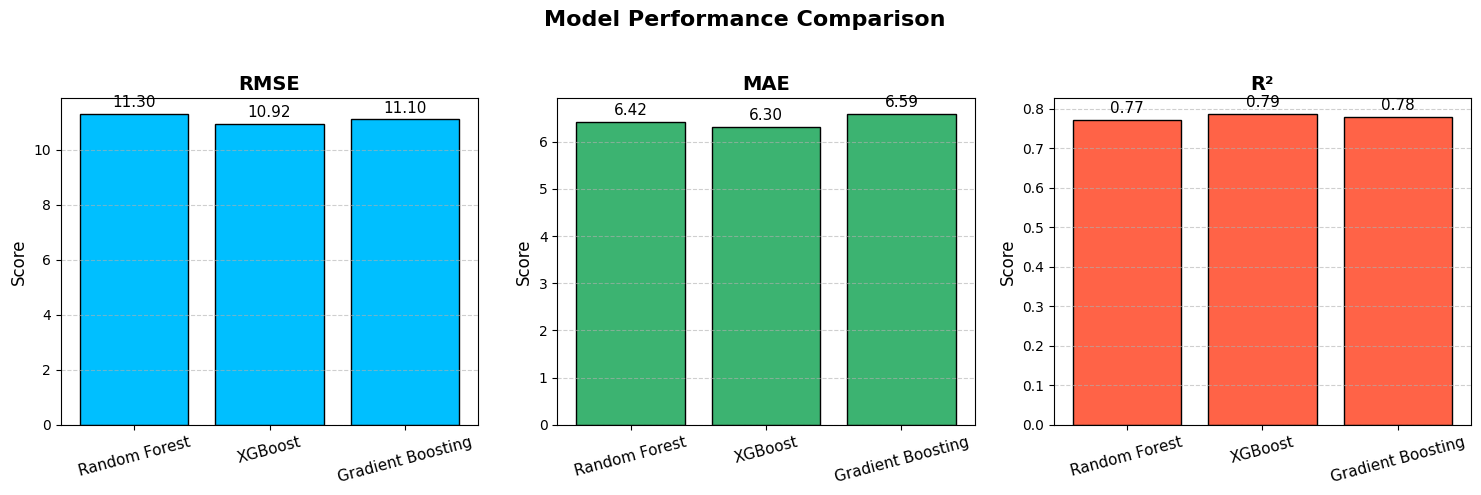

In [12]:
import matplotlib.pyplot as plt

# Model names for x-axis
model_names = ['Random Forest', 'XGBoost', 'Gradient Boosting']

# Metric values for each model
rmse_scores = [rf_rmse, xgb_rmse, gb_rmse]
mae_scores = [rf_mae, xgb_mae, gb_mae]
r2_scores = [rf_r2, xgb_r2, gb_r2]

# Improved plot design
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

metrics = [
    ('RMSE', rmse_scores, 'deepskyblue'),
    ('MAE', mae_scores, 'mediumseagreen'),
    ('R²', r2_scores, 'tomato')
]

for ax, (title, scores, color) in zip(axes, metrics):
    bars = ax.bar(model_names, scores, color=color, edgecolor='black')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xticklabels(model_names, rotation=15, fontsize=11)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points", ha='center', fontsize=11)

fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()